In [1]:
import pandas as pd
data = pd.read_csv("./ELCo/ELCo.csv")
emoji = data["Emoji"].values
english = data["English"].values

In [2]:
import re
for i in range(len(emoji)):
    text = emoji[i]
    pattern = r"(?<=\[EM\])[^[]+?(?=\[EM\])"
    matches = re.findall(pattern, text)
    result = ' '.join(match.replace('-', ' ') for match in matches)
    emoji[i] = result

In [3]:
# emoji text to vector
from keras import utils
from keras.preprocessing import text
import numpy as np

# X = np.append(emoji, english)

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(emoji)
sequences = tokenizer.texts_to_sequences(emoji)

emoji_num = utils.pad_sequences(sequences, maxlen=30, padding='post') # max length is actually 33

# emoji_num = X[:len(emoji)].copy()
# english_num = sequences[len(emoji):][0:2].copy()

In [4]:
from sentence_transformers import SentenceTransformer
# sentences = ["This is an example sentence", "Each sentence is converted"]
sbert_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# embeddings = model.encode(sentences)
# print(embeddings)
english_embeddings = sbert_model.encode(english)

/Users/xumingda/miniforge3/envs/tf3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# stratified validation set
val_list = []
train_list = []
cmp = ''
for i in range(len(english)):
    if english[i] != cmp:
        val_list.append(i)
        cmp = english[i]
    else:
        train_list.append(i)

In [6]:
X_train = emoji_num[train_list][:]
y_train = english_embeddings[train_list][:]
X_val = emoji_num[val_list][:]
y_val = english_embeddings[val_list][:]

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Flatten, SimpleRNN, LSTM, Conv1D, MaxPooling1D

model = Sequential()

model.add(Embedding(1000, 32, input_length=30))
model.add(Dropout(0.5))

# model.add(Conv1D(64, 3, padding='same', activation='relu', strides=1))
# model.add(MaxPooling1D())
# model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(768, activation='linear'))

# model.summary()

In [11]:
model.compile(optimizer='Adam', loss='cosine_similarity')

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8)

Epoch 1/50


2023-03-31 14:50:55.626729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 2s 10ms/step - loss: -0.3952 - val_loss: -0.4218
Epoch 2/50
  9/182 [>.............................] - ETA: 1s - loss: -0.4289

2023-03-31 14:50:57.480212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


182/182 [==============================] - 1s 7ms/step - loss: -0.4288 - val_loss: -0.4419
Epoch 3/50
182/182 [==============================] - 1s 7ms/step - loss: -0.4693 - val_loss: -0.4751
Epoch 4/50
182/182 [==============================] - 1s 7ms/step - loss: -0.5129 - val_loss: -0.4934
Epoch 5/50
182/182 [==============================] - 1s 7ms/step - loss: -0.5465 - val_loss: -0.5061
Epoch 6/50
182/182 [==============================] - 1s 7ms/step - loss: -0.5747 - val_loss: -0.5187
Epoch 7/50
182/182 [==============================] - 1s 8ms/step - loss: -0.5988 - val_loss: -0.5206
Epoch 8/50
182/182 [==============================] - 1s 7ms/step - loss: -0.6195 - val_loss: -0.5267
Epoch 9/50
182/182 [==============================] - 1s 7ms/step - loss: -0.6381 - val_loss: -0.5287
Epoch 10/50
182/182 [==============================] - 1s 7ms/step - loss: -0.6499 - val_loss: -0.5301
Epoch 11/50
182/182 [==============================] - 1s 8ms/step - loss: -0.6623 - val_los

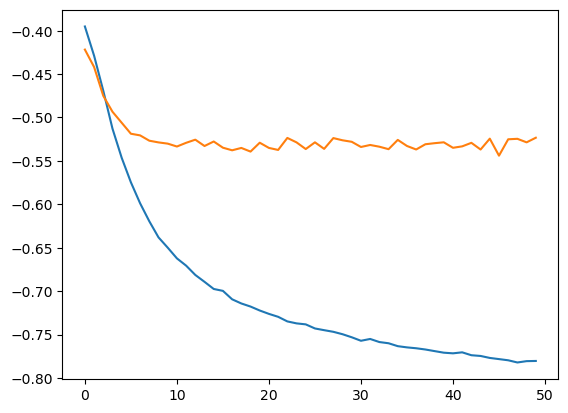

In [16]:
from matplotlib import pyplot as plt
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.show()

In [17]:
y_pred = model.predict(X_val)

7/7 [==============================] - 0s 5ms/step


2023-03-31 15:06:02.530251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [18]:
def cal_cos_similarity(x, y):
    cos = x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))
    return cos

In [32]:
english_set = english[val_list]
cos_sim = np.zeros((210,210))
for i in range(210):
    for j in range(210):
        cos_sim[i][j] = cal_cos_similarity(y_pred[i], y_val[j])

cos_sim_index = np.argsort(-cos_sim, axis=1)

In [41]:
top1 = 0; top5 = 0
for i in range(210):
    if i == cos_sim_index[i][0]:
        top1 += 1
    if i in cos_sim_index[i][0:5]:
        top5 += 1
    # if i not in cos_sim_index[i][0:200]:
    #     print(i)
print(top1/210, top5/210)

50
59
82
106
177
185
0.21428571428571427 0.47619047619047616
